In [18]:
import pydicom
from pydicom.data import get_testdata_file
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import scipy
from scipy.signal import find_peaks

tot_dcm={}
for j in [150,250]:
    source1=np.zeros((757,750,593)).astype(np.float32)
    for i in np.arange(1,6):
        ds = pydicom.dcmread("d:/Desktop/SFRT-Topas/vhee/vhee_patient/depth_test/results/dosetomedium_vhee_depthtest_"+str(j)+"__"+str(i)+".dcm")
        source1=np.add(source1,ds.pixel_array*ds.DoseGridScaling).astype(np.float32)
    source1=source1/1.6021766e-19/5e6*0.75e-6
    source1=np.swapaxes(source1,1,2)
    tot_dcm[j]=source1

In [19]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [2]:
#Make total dicoms #####################################################################
tot_dcm={}
for j in np.arange(250,250+1,10):
    source1=np.zeros((757,750,593))
    for i in np.arange(1,6):
        ds = pydicom.dcmread("d:/Desktop/SFRT-Topas/vhee/vhee_patient/depth_test/results/dosetomedium_vhee_depthtest_"+str(j)+"__"+str(i)+".dcm")
        source1+=ds.pixel_array*ds.DoseGridScaling
    print(ds.DoseGridScaling)
    tot_dcm[j]=np.around(source1/ds.DoseGridScaling).astype(np.uint16)
    ds.PixelData = tot_dcm[j].tobytes()
    ds[0x0020, 0x0032].value= [163.5935,155.156,-811.09]
    ds.DoseGridScaling=1/1.6021766e-19/5e6*ds.DoseGridScaling
    ds.PatientName = str(j)+' MV depth test 5M hist NEW'
    ds.save_as("d:/Desktop/SFRT-Topas/vhee/vhee_patient/depth_test/results/dosetomedium_vhee_depthtest_"+str(j)+"MV_tot.dcm")
########################################################
# source1=np.zeros((757,750,593))
# j=240
# for i in np.arange(1,6):
#     ds = pydicom.dcmread("d:/Desktop/SFRT-Topas/vhee/vhee_patient/depth_test/results/dosetomedium_vhee_depthtest_"+str(j)+"__"+str(i)+".dcm")
#     source1+=ds.pixel_array*ds.DoseGridScaling
# tot_dcm[j]=np.around(source1*1e8).astype(np.uint16)
# ds.PixelData = tot_dcm[j].tobytes()
# ds[0x0020, 0x0032].value= [163.5935,155.156,-811.09]
# ds.PatientName = str(j)+' new MV depth test 5M hist new'
# ds.save_as("d:/Desktop/SFRT-Topas/vhee/vhee_patient/depth_test/results/dosetomedium_vhee_depthtest_"+str(j)+"MV_tot_new.dcm")

8.3705935457464e-10


150MV 32.0 mm
250MV 42.0 mm


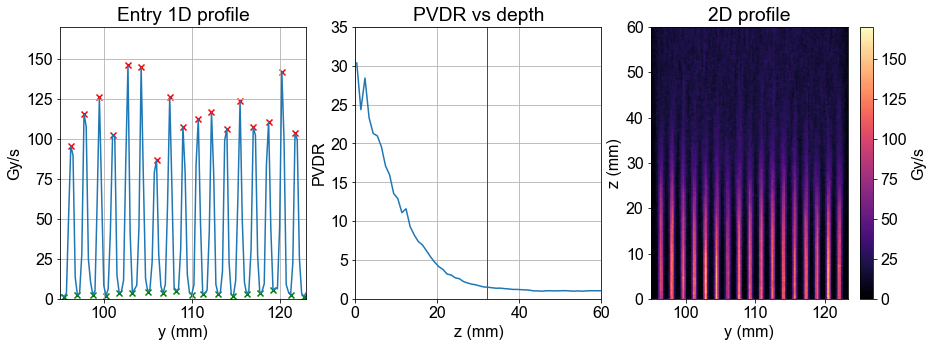

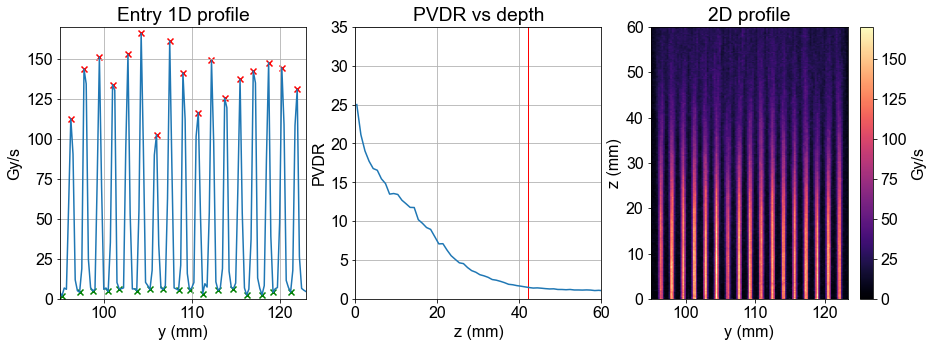

In [26]:
leftedge=380
rightedge=493
zslice=324
maxdose=170
yentry=573

y= np.arange(0,(rightedge-leftedge))*0.25
x= np.arange(0,300)*0.25


for i in [150,250]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    im1=ax3.imshow(tot_dcm[i][zslice],vmax=maxdose,aspect='auto',extent=(0,750*0.25,0,593*0.25),cmap='magma')
    ax3.set_ylabel('z (mm)')
    ax3.set_xlabel('y (mm)')
    ax3.set_xlim((leftedge*0.25,rightedge*0.25))
    ax3.set_ylim((0*0.25,60))
    fig.colorbar(im1,label='Gy/s')
    ax3.set_title('2D profile')
    
    
    ax1.plot(np.arange(leftedge,rightedge)*0.25,tot_dcm[i][zslice][yentry][leftedge:rightedge])
    ax1.set_ylim((0,maxdose))
    ax1.set_xlim(np.arange(leftedge,rightedge)[0]*0.25,np.arange(leftedge,rightedge)[-1]*0.25)
    ax1.set_ylabel('Gy/s')
    ax1.set_xlabel('y (mm)')
    ax1.grid()
    
    
    peaks= find_peaks(tot_dcm[i][zslice][yentry][leftedge:rightedge],height=0.5e8*0.75e-6,distance=4)[0]
    valleys= find_peaks(-tot_dcm[i][zslice][yentry][leftedge:rightedge],distance=4)[0]
    ax1.scatter(y[peaks]+leftedge*0.25,tot_dcm[i][zslice][yentry][leftedge+peaks],marker='x',c='red')
    ax1.scatter(y[valleys]+leftedge*0.25,tot_dcm[i][zslice][yentry][leftedge+valleys],marker='x',c='green')
    pvdr=np.mean(tot_dcm[i][zslice][yentry][leftedge+peaks])/np.mean(tot_dcm[i][zslice][yentry][leftedge+valleys])
    ax1.set_title('Entry 1D profile')

    pvdr_depth=[]
    pvdr_error=[]
    mean_peaks=[]
    mean_valleys=[]
    peak_error=[]
    valley_error=[]
    for j in np.flip(np.arange(yentry-299,yentry+1)):
        mean_peaks.append(np.mean(tot_dcm[i][zslice][j][leftedge+peaks]))
        mean_valleys.append(np.mean(tot_dcm[i][zslice][j][leftedge+valleys]))
    pvdr_depth=[mean_peaks[k]/mean_valleys[k] for k in np.arange(0,len(mean_valleys))]
    n=4
    mean_peaks_avg=[sum(mean_peaks[k:k+n])/n for k in range(0,len(mean_peaks),n)]
    mean_valleys_avg=[sum(mean_valleys[k:k+n])/n for k in range(0,len(mean_valleys),n)]
    pvdr_depth_avg=[mean_peaks_avg[k]/mean_valleys_avg[k] for k in np.arange(0,len(mean_valleys_avg))]
    x_avg=[sum(x[k:k+n])/n for k in range(0,len(x),n)]
    ax2.plot(x_avg,pvdr_depth_avg,label=str(i)+'MV')
    ax2.grid()
    ax2.set_ylim((0,41))
    ax2.set_title("PVDR vs depth")
    ax2.set_ylabel('PVDR')
    ax2.set_xlabel('z (mm)')
    DOC= [w*0.25*n for w in np.arange(0,len(pvdr_depth_avg)) if np.max(pvdr_depth_avg[w:w+5])<=1.5][0]
    print(str(i)+'MV '+str(DOC)+' mm')
    #np.save('d:/Desktop/SFRT-Topas/vhee/vhee_patient/depth_test/results/DOC_PVDR'+str(i)+'.npy',np.array([DOC,np.max(pvdr_depth_avg)]))  
    ax2.vlines(DOC,0,100,colors='red',lw=1)
    ax2.set_ylim(0,35)
    ax2.set_xlim(0,60)

<Figure size 576x576 with 0 Axes>

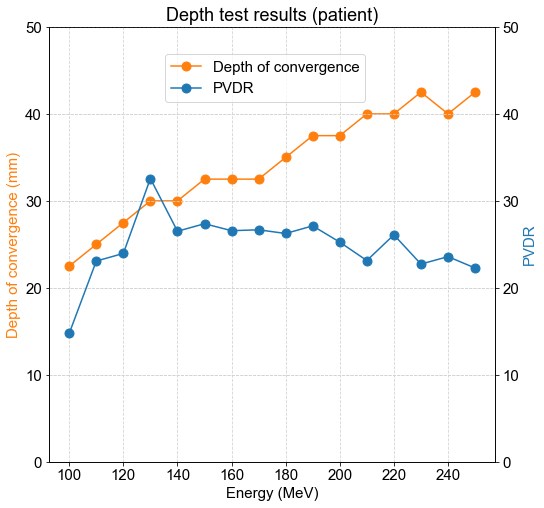

In [6]:
def align_y_axis(ax1, ax2, minresax1, minresax2,numticks):
    """ Sets tick marks of twinx axes to line up with x total tick marks

    ax1 and ax2 are matplotlib axes
    Spacing between tick marks will be a factor of minresax1 and minresax2"""

    ax1ylims = ax1.get_ybound()
    ax2ylims = ax2.get_ybound()
    ax1factor = minresax1 * (numticks-1)
    ax2factor = minresax2 * (numticks-1)
    ax1.set_yticks(np.linspace(ax1ylims[0],
                               ax1ylims[1]+(ax1factor -
                               (ax1ylims[1]-ax1ylims[0]) % ax1factor) %
                               ax1factor,
                               numticks))
    ax2.set_yticks(np.linspace(ax2ylims[0],
                               ax2ylims[1]+(ax2factor -
                               (ax2ylims[1]-ax2ylims[0]) % ax2factor) %
                               ax2factor,
                               numticks))

energy=np.arange(100,250+1,10)
DOC=[]
PVDR=[]
for i in energy:
    DOC.append(np.load('d:/Desktop/SFRT-Topas/vhee/vhee_patient/depth_test/results/DOC_PVDR'+str(i)+'.npy')[0])
    PVDR.append(np.load('d:/Desktop/SFRT-Topas/vhee/vhee_patient/depth_test/results/DOC_PVDR'+str(i)+'.npy')[1])

figure(1,figsize=(8,8))
fig, ax1=plt.subplots(figsize=(8,8))
plt.plot(energy,DOC,marker='o',label='Depth of convergence',markersize=9,c='tab:orange')
plt.ylabel('Depth of convergence (mm)',c='tab:orange')
plt.xlabel('Energy (MeV)')
plt.grid(c='lightgray',axis='both',ls='--')
plt.ylim(bottom=0)
ax2=ax1.twinx()
plt.plot(energy,PVDR,marker='o',markersize=9,label='PVDR')
plt.ylabel('PVDR',c='tab:blue')
plt.grid(c='lightgray',axis='both',ls='--')
plt.ylim(bottom=0)
fig.legend(loc="upper center", bbox_to_anchor=(0.5,0.8455))
plt.title('Depth test results (patient)')

align_y_axis(ax1,ax2,5,5,6)